# Senior Transit Access to Grocery Stores 

#### Research Question: Where do gaps in transit access to grocery stores exist for residents ages 65+ in the city of Los Angeles?


This notebook explores vehicle ownership and access for seniors. We want to explore how many seniors drive compared to the general population in Los Angeles. This will further help demonstrate a need for public transit access for seniors. 

In [1]:
#first we import pandas 
import pandas as pd
import geopandas as gpd

Use Census API to pull in the columns that we need for LA City.

In [2]:
import requests
apirequest = 'https://api.census.gov/data/2021/acs/acs5?get=NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E&for=place:44000&in=state:06'
usr_key = f"&key=4c422219a890d0597a042d9ebad9311b022cfd4d"
#Put it all together in one f-string:
query_url = f"{apirequest}{usr_key}"
# Use requests package to call out to the API
response = requests.get(query_url)

Now, I convert these results to a dataframe that I can work with in Python.

In [3]:
# First we have to convert the text to a json.
censusdata=response.json()

# Then we have to convert this to a dataframe we can work with.
census_df=pd.DataFrame(censusdata)

census_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,place
1,"Los Angeles city, California",17341,10951,493319,151011,144350,47232,729841,77809,06,44000


The variable names are in a row, so I have to create column names that copy row 0.

In [4]:
census_df.columns = census_df.iloc[0]
census_df

,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,place
0,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,place
1,"Los Angeles city, California",17341,10951,493319,151011,144350,47232,729841,77809,06,44000


Now we will rename our columns.

In [5]:
census_df=census_df.rename(columns={'B25045_003E':'Owner no vehicle', 'B25045_006E':'Owner no vehicle 65+',
                         'B25045_007E':'Owner with vehicle', 'B25045_010E' : 'Owner with vehicle 65+',
                         'B25045_012E' : 'Renter no vehicle', 'B25045_015E' : 'Renter no vehicle 65+',
                         'B25045_016E' : 'Renter with vehicle', 'B25045_019E' : 'Renter with vehicle 65+'},)
census_df.head(5)

,NAME,Owner no vehicle,Owner no vehicle 65+,Owner with vehicle,Owner with vehicle 65+,Renter no vehicle,Renter no vehicle 65+,Renter with vehicle,Renter with vehicle 65+,state,place
0,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,place
1,"Los Angeles city, California",17341,10951,493319,151011,144350,47232,729841,77809,06,44000


Now, I want to drop row 0 (which contains the column names)

In [6]:
# Drop row 0 by creating a new dataframe with columns 1:
census_clean = census_df.iloc[1:]

Now I must cast all of the columns (other than the geography names) as integers so that I can use them in calculations.

In [7]:
census_clean=census_clean.astype({'Owner no vehicle':'int', 'Owner no vehicle 65+':'int', 'Owner with vehicle':'int', 'Owner with vehicle 65+': 'int', 
                                  'Renter no vehicle':'int', 'Renter no vehicle 65+' : 'int', 'Renter with vehicle' : 'int' , 'Renter with vehicle 65+' : 'int'})

In [8]:
# Check that this worked.
census_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 1 to 1
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   NAME                     1 non-null      object
 1   Owner no vehicle         1 non-null      int64 
 2   Owner no vehicle 65+     1 non-null      int64 
 3   Owner with vehicle       1 non-null      int64 
 4   Owner with vehicle 65+   1 non-null      int64 
 5   Renter no vehicle        1 non-null      int64 
 6   Renter no vehicle 65+    1 non-null      int64 
 7   Renter with vehicle      1 non-null      int64 
 8   Renter with vehicle 65+  1 non-null      int64 
 9   state                    1 non-null      object
 10  place                    1 non-null      object
dtypes: int64(8), object(3)
memory usage: 220.0+ bytes


Now we create a new dataframe with calculated percentages.

In [9]:
# Calculate necesarry totals.
census_clean['Total HH']=census_clean['Owner no vehicle']+census_clean['Owner with vehicle']+census_clean['Renter no vehicle']+census_clean['Renter with vehicle']
census_clean['Senior HH']=census_clean['Owner no vehicle 65+']+census_clean['Owner with vehicle 65+']+census_clean['Renter no vehicle 65+']+census_clean['Renter with vehicle 65+']
census_clean['Total No Vehicle']=census_clean['Owner no vehicle']+census_clean['Renter no vehicle']
census_clean['Senior No Vehicle']=census_clean['Owner no vehicle 65+']+census_clean['Renter no vehicle 65+']

In [10]:
# Calculate rounded, plot-friendly percentages.
census_clean['Pct Households Without a Vehicle'] = round(census_clean['Total No Vehicle']/census_clean['Total HH']*100)
census_clean['Pct Senior-Headed Households Without a Vehicle']= round(census_clean['Senior No Vehicle']/census_clean['Senior HH']*100)

In [11]:
# Create a new dataframe with just my geography names and final percentages.
census_percentages=census_clean[['NAME','Pct Households Without a Vehicle', 'Pct Senior-Headed Households Without a Vehicle']]
census_percentages

,NAME,Pct Households Without a Vehicle,Pct Senior-Headed Households Without a Vehicle
1,"Los Angeles city, California",12.0,20.0


Now I can make my plot!

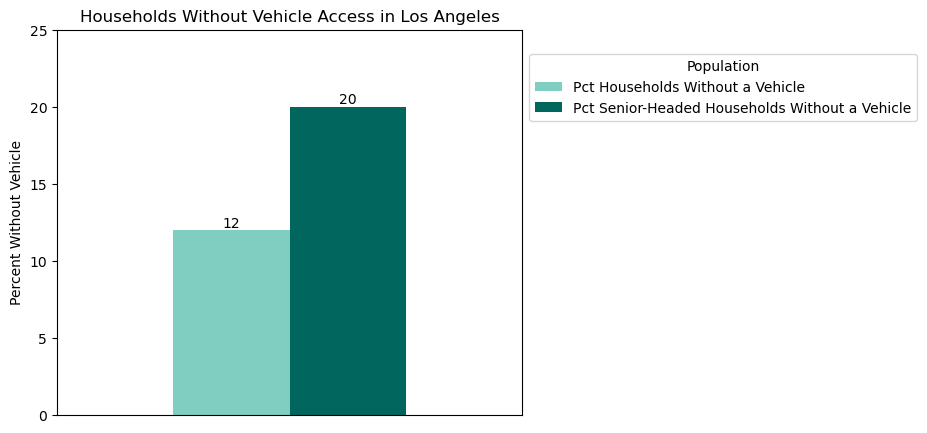

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,5))

#Create bar plot and label the two bars with their values.
ax = census_percentages.plot(ax=ax, kind='bar', color=['#80cdc1','#01665e'] , legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis so it doesn't have a subtitle or ticks.
plt.xlabel(None)
ax.set_xticks([])

# Ajust y-axis so that it has desired subtitle and ticks.
plt.ylabel("Percent Without Vehicle")
ax.set_yticks((0,5,10,15,20,25))

#Adjust table and legend.
plt.title("Households Without Vehicle Access in Los Angeles")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Population')

plt.show()

#### This chart demonstrates that seniors are much less likely to have access to a vehicle, making public transit access vital to their daily lives. We will explore grocery store and transit access further in our other notebooks. 

### Group Name: Snake Emoji 
### Group members: Monisha Reginald, Carolyn Pugh, Lucy Briggs, Adriana Ochoa 

#### Division of labor:

Monisha: Access to grocery stores (grocery store buffer map, grocery store interactive map, sennior access to grocery stores chart) 

Carolyn: Metro stops map, Seniors and transit stops map

Lucy: LA senior density maps, LA senior density charts 

Adriana: vehicle access (however I had to rely heavily on Monisha's help and all credit is due to her), and midterm slideshow